# Исследование влияния кодирования данных на качество работы линейной регрессии

Данные клиентов страховой компании в целях безопасности требуется хранить в закрытом виде. Кодирование предлагается осуществить путем умножения матрицы данных клиентов на произвольную обратимую матрицу. От нас требуется исследовать, повлияет ли данное преобразование на работу модели линейной регрессии, а также оценить надежность такой защиты и написать непосредственный алгоритм кодирования.

# Описание данных

Файл ***insurance.csv***, содержащий для каждого клиента следующие параметры:
- **Пол**
- **Возраст**
- **Зарплата**
- **Количество членов семьи**
- **Количество страховых выплат клиенту за последние 5 лет (целевой признак)**

## 1. Загрузка данных

Импортируем необходимые модули:

In [26]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error

Откроем полученную таблицу и выведем информацию о ней, а также несколько строк для наглядности:

In [8]:
insurance_data = pd.read_csv('/datasets/insurance.csv')
display(insurance_data.head())
insurance_data.info()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


В таблице представлены данные в целочисленном и вещественном виде, пропусков нет. Построим матрицу диаграмм рассеяния, чтобы изучить распределения и корреляцию между различными признаками.

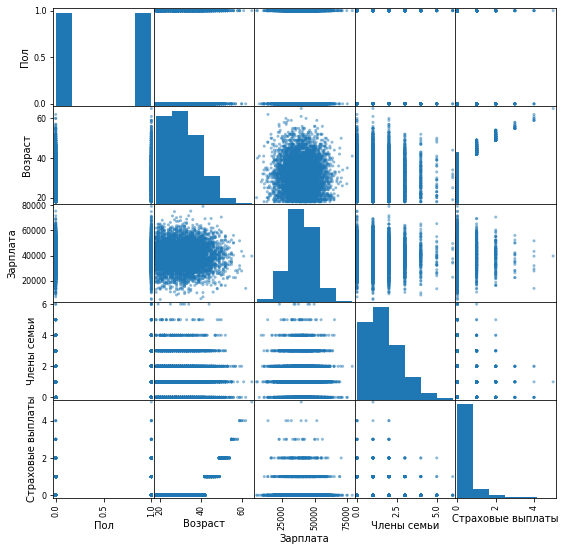

In [9]:
pd.plotting.scatter_matrix(insurance_data, figsize = (9,9), hist_kwds={'bins':6})
plt.show()

Можно видеть, что выбросы и аномальные значения признаков отсутствуют. Отметим также сильную корреляцию целевой переменной с признаком **"Возраст"**.

Выделим признаки в переменную ***features***, целевой признак - в переменную ***target***:

In [10]:
features = insurance_data.drop(columns = 'Страховые выплаты')
target = insurance_data['Страховые выплаты']
print('Размер features:', features.shape, 
      ', размер target:', target.shape)

Размер features: (5000, 4) , размер target: (5000,)


## 2. Умножение матриц

Перед нами поставлена задача разработать алгоритм преобразования содержащихся в таблице данных с тем, чтобы это преобразование не оказало влияния на качество машинного обучения. В качестве такого преобразования предлагается использовать умножение матрицы признаков на квадратную обратимую матрицу $\boldsymbol P$. Покажем, что такое преобразование не ухудшит качества работы модели линейной регрессии для данного набора признаков:

Итак, нам даны:

- $\pmb X$ — матрица признаков размера $m \times n$, где $m$ - количество строк (наблюдений), а $n$ - число признаков для каждого наблюдения; в случае, если в нашей модели регрессии присутствует свободный член (bias), можно дописать слева к $\pmb X$ столбец из единиц. В нашем доказательстве это не будет иметь значения.
- $\pmb y$ — вектор целевого признака (длины $m$).

Мы построили модель линейной регрессии, то есть нашли вектор весов $\pmb w$, который при умножении на матрицу признаков дает нам вектор предсказаний $\pmb {\hat y}$:

$$\pmb{\hat y} = \pmb{Xw} \tag 1$$

При этом $MSE(\pmb y,\pmb{\hat y})$ (среднеквадратичная ошибка) должна быть минимальна, то есть выполняется равенство:

$$\pmb w = (\pmb X^\top \pmb X)^{-1}\pmb X^\top \pmb y \tag 2$$

Посмотрим, что это означает с геометрической точки зрения. Каждой строке $i$ матрицы $\pmb X$ соответствует точка $\pmb x_i$ в пространстве размерности $n + 1$ с координатами $[x_{i,1},..., x_{i,n}, y_i]$. Тогда уравнение $\pmb{\hat y} = \pmb{xw}$ описывает прямую (или, в общем случае, гиперплоскость) регрессии в этом пространстве, квадрат расстояния до которой от каждой точки, содержащейся в матрице признаков, минимален.

В результате умножения $\pmb X$ на $\pmb P$ получим новую матрицу признаков $\pmb X' = \pmb {XP}$. С геометрической точки зрения умножение на квадратную матрицу размера $n \times n$ соответствует линейному преобразованию пространства, которое каждую точку $\pmb x_i$ с координатами $[x_{i,1}, ..., x_{i,n}, y_i]$ переводит в точку $\pmb x'_i$ с координатами $ \pmb {x_iP} = [x_{i,1}p_{:,1},  ..., x_{i,n}p_{:,n}, y_i]$. Если  $\pmb P$ к тому же обратима, то, такое преобразование однозначно и существует обратное преобразование $\pmb P^{-1}$, которое все точки $\pmb x'_i$ переводит обратно в $\pmb x_i$.

Свойством линейного преобразования является то, что прямые линии после такого преобразования остаются прямыми. Соответственно, прямая регрессии $\pmb{\hat y} = \pmb{xw}$ перейдет в прямую $\pmb{\hat y} = \pmb{xPw}$. Несложно доказать, что эта прямая также будет оптимальной с точки зрения минимизации $MSE$. Для доказательства решим уравнение оптимизации для наших признаков после преобразования:

$$\pmb w' = (\pmb X'^\top \pmb X')^{-1} \pmb X'^\top \pmb y$$  

$$= ((\pmb {XP})^\top \pmb{XP})^{-1} (\pmb{XP})^\top \pmb{y} \tag{поскольку $\pmb X' = \pmb {XP}$}$$ 

$$= (\pmb P^\top \pmb X^\top \pmb{XP})^{-1}\pmb P^\top \pmb X^\top \pmb y 
\tag{$(\pmb {AB})^\top = \pmb B^\top \pmb A^\top$}$$ 

$$= \pmb P^{-1}(\pmb X^\top \pmb X)^{-1}(\pmb P^\top)^{-1}\pmb P^\top \pmb X^\top \pmb y 
\tag{$(\pmb {AB})^{-1} = \pmb B^{-1} \pmb A^{-1}$ для обратимых $\pmb A$ и $\pmb B$}$$ 

$$= \pmb P^{-1}(\pmb X^\top \pmb X)^{-1}\pmb X^\top \pmb y 
\tag{$\pmb A^{-1}\pmb A = \pmb I_n $}$$  
$= \pmb P^{-1}\pmb w \tag{из уравнения $(2)$}$  

Подставив полученный вектор весов $\pmb w'$ в формулу $MSE$ получим:

$MSE(\pmb X'\pmb w', \pmb y) = MSE(\pmb {XPP}^{-1}\pmb w, \pmb y) = MSE(\pmb {Xw}, \pmb  y)$

То есть среднеквадратичные ошибки для обеих прямых равны. Заодно мы получили и соотношение параметров регрессии до и после преобразования:
$$\pmb w' = \pmb P^{-1}\pmb w \tag 3$$




## Вывод
В качестве преобразования для таблицы с данными клиентов предлагается использовать умножение матрицы признаков на обратимую квадратную матрицу. При этом, как показано выше, качество линейной регрессии при таком преобразовании не ухудшится. Веса линейной регрессии до и после преобразования связаны соотношением (3).

## 3. Алгоритм преобразования
На основе приведенных в предыдущем пункте обоснований напишем функцию, которая будет производить преобразование данных. Матрицу $\pmb P$ сформируем с помощью функции *np.random.normal*:

In [11]:
def transformation(features):
    n = features.shape[1]       # число столбцов Х
    while True:
        transform_matrix = np.random.normal(size = (n, n)) # Зададим случайную матрицу преобразования
        if np.linalg.det(transform_matrix) != 0:           # Проверим обратимость матрицы (определитель != 0)
            feats_transformed = pd.DataFrame(data = features.dot(transform_matrix))
            feats_transformed.columns = features.columns
            return transform_matrix, feats_transformed     # возвращаем P и X'

Проверим работу функции:

In [18]:
p, feats_transformed = transformation(features)
print('Матрица преобразования (P):\n')
print(p)
print('\n\nНесколько строк преобразованной матрицы:')
display(feats_transformed.head(10))

Матрица преобразования (P):

[[-0.122615   -0.44768523  0.95758717  0.93879747]
 [-1.30341372  1.08417096 -0.46090147 -0.19532938]
 [ 0.96438417 -0.09858059 -0.38945419 -1.11862855]
 [-0.31905761 -2.14826893  0.83537594 -0.1590931 ]]


Несколько строк преобразованной матрицы:


,Пол,Возраст,Зарплата,Члены семьи
0,47779.573328,-4847.741962,-19334.031821,-55491.205128
1,36586.322472,-3698.338636,-14819.625311,-42517.029334
2,20214.268628,-2038.751328,-8191.904132,-23496.864207
3,40186.810196,-4092.339343,-16248.247901,-46651.230847
4,25133.808707,-2543.044168,-10176.702013,-29200.735711
5,39482.943559,-3999.928858,-15984.812214,-45871.549307
6,38234.457789,-3876.110781,-15476.678161,-44416.550868
7,37191.244876,-3787.147069,-15040.155179,-43183.643032
8,47882.528814,-4863.020876,-19370.672732,-55602.091337
9,49816.510815,-5064.518730,-20147.737506,-57838.567129


Можно видеть, что данные достаточно хорошо закрыты. Например, столбец **Пол**, который ранее принимал только два значения (*0* или *1*), после преобразования содержит разные значения в каждой записи, а для полей **Возраст**, **Члены семьи** и **Зарплата** нельзя понять даже порядок величин. Это связано с тем, что теперь каждое поле является линейной комбинацией остальных полей.
Без знания матрицы $\pmb P$ открыть исходные данные очень трудно. Для этого злоумышленнику нужно решить систему уравнений $\pmb {XP} = \pmb X'$ относительно неизвестных $\pmb X$ и $\pmb P$. В этой системе будет $mn$ уравнений (по одному для вычисления каждого элемента матрицы $\pmb X'$), а неизвестных $mn + n^2$ (каждый элемент $X$ и $P$), так что в общем случае решений будет бесконечно много.

Однако стоит отметить, что если известна хотя бы $n$ строк исходной матрицы, то нахождение $\pmb P$, а следовательно и всех остальных данных, не представляет никакого труда. Для этого необходимо решить для известных строк систему уравнений $\pmb {XP} = \pmb X'$ относительно $\pmb P$, где число уравнений равно числу неизвестных.

Посмотрим матрицу диаграмм рассеяния для преобразованных признаков:

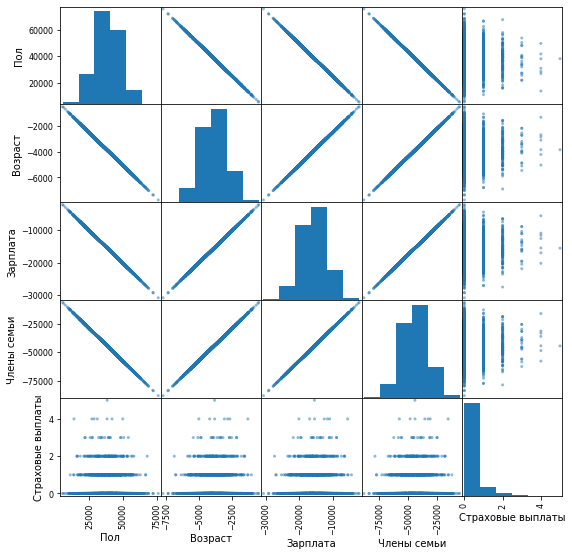

In [24]:
pd.plotting.scatter_matrix(feats_transformed.join(target), figsize = (9,9), hist_kwds={'bins':6})
plt.show()

По диаграммам рассеяния и гистограммам признаков выяснить исходные признаки также не выйдет.

Проверим, корректно ли раскрываются наши данные. Найдем обратную матрицу $\pmb P^{-1}$ и умножим на нее преобразованную таблицу:

In [25]:
p_inverse = np.linalg.inv(p)
print('Обратная матрица преобразования:\n')
print(p_inverse)

feats_returned = pd.DataFrame(data = feats_transformed.dot(p_inverse)).round() 
feats_returned.columns = features.columns
display(feats_returned.head())

Обратная матрица преобразования:

[[ 0.08877195 -0.54413681  0.21258941 -0.30286544]
 [ 0.92816004  0.56019893  0.73945882 -0.41012948]
 [ 2.26931224  1.0635368   1.72094114 -0.01514394]
 [-0.79533234 -0.88874946 -1.37499275 -0.21968862]]


,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,-0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


Сравним результаты обратного преобразования с нашей исходной таблицей (найдем среднюю абсолютную ошибку):

In [28]:
print('Она равна', mean_absolute_error(features, feats_returned))

Она равна 8.185452315956354e-15


Как видим, разница ничтожно мала (и вызвана ошибкой округления чисел с плавающей точкой в python), соответственно, восстановить начальную таблицу возможно.

## Вывод

Нами предложен алгоритм преобразования данных таблицы. Он состоит из следующих шагов:
1. С помощью функции *np.random.normal* формируется случайная квадратная матрица размера $n \times n$; 
2. Проверяется ее обратимость (определитель не равен нулю);
3. Исходная таблица умножается на матрицу преобразования.

Далее мы показали, что по полученной таблице без знания $P^{-1}$ восстановить исходную практически невозможно, а также что обратное преобразование не "портит" наши данные (преобразовывать туда-обратно при необходимости можно сколько угодно раз).

## 4. Проверка алгоритма

На данном шаге мы проверим наши теоретические выкладки и сравним качество регрессии на открытых и преобразованных признаках.

Построим модель линейной регрессии и обучим ее на открытых признаках:

In [37]:
model = LinearRegression()
model.fit(features, target)
w = model.coef_         # Сохраним веса модели
print('Веса:', w)

Веса: [ 7.92580543e-03  3.57083050e-02 -1.70080492e-07 -1.35676623e-02]


Теперь найдем коэффициент детерминации (R2) предсказаний модели на тренировочном наборе:

In [40]:
predictions = model.predict(features)
r2_before = r2_score(target, predictions)
print('R2 для модели до преобразования', r2_before)

R2 для модели до преобразования 0.42494550286668


Значение метрики не очень высокое, но нахождение оптимальной модели нам в этом задании не требуется.

Теперь обучим модель на признаках после преобразования:

In [44]:
model_2 = LinearRegression()
model_2.fit(feats_transformed, target)
w_2 = model_2.coef_
print('Веса:', w_2)

Веса: [-0.01461747  0.03292454  0.0561684  -0.03505849]


Найдем R2 для второй модели:

In [50]:
predictions_2 = model_2.predict(feats_transformed)
r2_after = r2_score(target, predictions_2)
print('R2 для модели после преобразования', r2_after)
print('Разница R2 до и после преобразования', r2_after - r2_before)

R2 для модели после преобразования 0.4249455028666881
Разница R2 до и после преобразования 8.104628079763643e-15


Как видно, качество модели до и после преобразования идентично.

Напоследок проверим соотношение весов первой и второй модели (уравнение (3)):

In [55]:
print('Разница между векторами весов w_2 и P_inverse.dot(w) равна', 
      mean_absolute_error(p_inverse.dot(w), w_2))

Разница между векторами весов w_2 и P_inverse.dot(w) равна 1.993891163287742e-13


Разница между $\pmb w'$ и $\pmb P^{-1}\pmb w$ ничтожно мала, так что уравнение верно.

## Вывод

На данном шаге мы сравнили качество регрессии до и после преобразования данных. Разница полученных метрик R2 получилась пренебрежимо малой, что позволяет считать, что задание выполнено верно.